In [5]:
import os
import math
from shutil import copyfile

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from utils.loader import environments, WeatherTransform

from utils.common import setup_seed 
from tqdm import tqdm
from utils.loader import tensor2label

class DomainClassifier(nn.Module):
    def __init__(self, domin_num=10) -> None:
        super(DomainClassifier, self).__init__()
        
        # adatped from modern backbone, change last fc to adopt domain
        self.net = models.resnet18(pretrained=True)
        ftr_num = self.net.fc.in_features
        self.net.fc = nn.Linear(ftr_num, domin_num)

    def forward(self, x):
        return self.net(x)

class FrequencyFilter(nn.Module):
    def __init__(self, h=256, w=256, channel=3) -> None:
        super(FrequencyFilter, self).__init__()
        self.filter = nn.Parameter(torch.ones(channel, h, w))

    def forward(self, img):
        fft_img = torch.fft.fftn(img, dim=(-2,-1))
        amplitude = torch.abs(fft_img)
        phase = torch.angle(fft_img)
        amplitude_ = self.filter * amplitude 
        ret = torch.real(torch.fft.ifftn(torch.polar(amplitude_, phase), dim=(-2,-1)))
        return ret
    
class MyDataset(datasets.ImageFolder):
    def __init__(self, root, transform = None, target_transform = None, style='normal', h=256, w=256):
        super().__init__(root, transform = transform, target_transform = target_transform)
        self.h = h 
        self.w = w 
        self.weather = style

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        t_normal = transforms.Compose(
                [
                    transforms.Resize((self.h, self.w), interpolation=InterpolationMode.BICUBIC),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            )
        
        t_aug = transforms.Compose(
                [
                    transforms.Resize((self.h, self.w), interpolation=InterpolationMode.BICUBIC),
                    WeatherTransform(aug=self.weather),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            )
        t = transforms.Compose(
                [
                    transforms.Resize((self.h, self.w), interpolation=InterpolationMode.BICUBIC),
                    WeatherTransform(aug=self.weather),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            )
        
        img_normal = t_normal(img)
        img_aug = t_aug(img)
        return img_aug, img_normal 

    def __len__(self):
        return len(self.imgs)
    
from matplotlib import pyplot as plt

def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.numpy()
    plt.imshow((np.transpose(img, (1,2,0)) * 255).astype('uint8'))
    plt.axis('off')
    plt.show() 
    
def test(style='fog', batchsize=8, epoch=1, filter_name=None):
    if filter_name==None:
        filter_name=style
    learnable_filter = FrequencyFilter()
    data_set = MyDataset(os.path.join(os.getcwd(), 'University-Release', 'test', 'query_drone'), style=style)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=batchsize, shuffle=True, num_workers=0, pin_memory=False)
    save_path = os.path.join(os.getcwd(), 'model', 'FFM', '{}_{:03d}.pth'.format(filter_name, epoch))
    learnable_filter.load_state_dict(torch.load(save_path)) 

    dataiter = iter(data_loader)
    img_aug, img = dataiter.next()
    with torch.no_grad():
        outputs = learnable_filter(img_aug)

    n = np.random.choice(list(range(batchsize)))

    imshow(img_aug[n])
    imshow(outputs[n])
    imshow(img[n])

def test2(style='fog', batchsize=8, epoch=1):
    learnable_filters = {}
    for i in environments:
        if i == 'normal':
            continue
        learnable_filters[i] = FrequencyFilter()
        save_path = os.path.join(os.getcwd(), 'model', 'FFM', '{}_{:03d}.pth'.format(i, epoch))
        learnable_filters[i].load_state_dict(torch.load(save_path)) 

    data_set = MyDataset(os.path.join(os.getcwd(), 'University-Release', 'test', 'query_drone'), style=style)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=batchsize, shuffle=True, num_workers=0, pin_memory=False)

    dataiter = iter(data_loader)
    img_aug, img = dataiter.next()
    with torch.no_grad():
        outputs = learnable_filters[style](img_aug)

    n = np.random.choice(list(range(batchsize)))

    imshow(img_aug[n])
    imshow(outputs[n])
    imshow(img[n])

def full_test(batchsize=8, epoch=1):
    learnable_filters = {}
    for i in environments:
        if i == 'normal':
            continue
        learnable_filters[i] = FrequencyFilter()
        save_path = os.path.join(os.getcwd(), 'model', 'FFM', '{}_{:03d}.pth'.format(i, epoch))
        learnable_filters[i].load_state_dict(torch.load(save_path)) 

    domain_classifier = DomainClassifier()
    save_path = os.path.join(os.getcwd(), 'model', 'Ours', '{}_{:03d}.pth'.format('DomainClassifier', 60))
    domain_classifier.load_state_dict(torch.load(save_path)) 
    
    from utils.loader import init_dataset_test
    image_datasets, dataloaders, dataset_sizes = init_dataset_test(name='University-Release', w=256, h=256, style='mixed', batchsize=batchsize)
    data_loader = dataloaders['query_drone']

    dataiter = iter(data_loader)
    img_aug, _, gt_w = dataiter.next()
    with torch.no_grad():
        logits = domain_classifier(img_aug) 
        pred = tensor2label(logits)
        xx = list()
        for i in range(len(pred)):
            if pred[i]=='normal':
                xx.append(img_aug[i])
            else:
                filtered = learnable_filters[pred[i]](img_aug[i].unsqueeze(0))
                xx.append(filtered[0])
        outputs = torch.stack(xx, 0)



    n = np.random.choice(list(range(batchsize)))
    imshow(img_aug[n])
    imshow(outputs[n])
    #imshow(img[n])

from MLPN.utils import get_id, SAM, SupConLoss, one_LPN_output, fliplr, scale_img, extract_feature
from LPN.image_folder_ import CustomData160k_drone, CustomData160k_sat
from utils.competition import get_result_rank10, get_SatId_160k
from MLPN.model import CSWinTransv2_threeIn
import tarfile
import zipfile

def extract_feature_f(model, domain_classifier, learnable_filters, dataloaders, block=4, decouple=True, infonce=1, ms=[1]):
    features = torch.FloatTensor()
    for data in tqdm(dataloaders, desc='Extract {} feature'.format('drone')):
        img, label = data 
        #print(img.shape)
        n, c, h, w = img.size()
        ff = torch.FloatTensor(n,512,block).zero_().cuda()
        img = img.cuda()

        logits = domain_classifier(img) 
        pred = tensor2label(logits)
        xx = list()
        for i in range(len(pred)):
            if pred[i]=='normal':
                xx.append(img[i])
            else:
                filtered = learnable_filters[pred[i]](img[i].unsqueeze(0))
                xx.append(filtered[0])
        img_ = torch.stack(xx, 0).cpu()
        #print(img_.shape)

        for i in [img_, fliplr(img_)]:
            for scale in ms:
                input_img = scale_img(i, scale).cuda()# .requires_grad_()
                outputs = model(input_img)
                ff += outputs[0]

        fnorm = torch.norm(ff, p=2, dim=1, keepdim=True) * np.sqrt(block) 
        ff = ff.div(fnorm.expand_as(ff)).view(ff.size(0), -1)
        features = torch.cat((features,ff.data.cpu()), 0)
    return features

def get_competition_submit(data160k_dir='D://dataset/university-160k-wx', save_file = 'answer.txt', pth=None, multiple_scale=[1], batchsize=128, MLPN_name='net_170.pth', FFM_epoch=1, block=4):
        # a part of test set of UAVM'24 competition is provided as tar file
        if not os.path.exists(os.path.join(data160k_dir, 'gallery_satellite_160k')):
            tar_file = os.path.join(data160k_dir, 'gallery_satellite_160k.tar.gz')
            if os.path.isfile(tar_file):
                print('Found dataset tar file. Extracting...')
                with tarfile.open(tar_file, 'r:gz') as tar:
                    tar.extractall(path=data160k_dir)
                print('Extract done')
        else:
            print('Found dataset')

        query_name = os.path.join(data160k_dir, 'query_drone_name.txt')
        if os.path.isfile(save_file):
            os.remove(save_file) 
            os.remove('answer.zip')
        results_rank10 = [] 

        data_transforms = transforms.Compose([
            transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        image_datasets = {}
        image_datasets['gallery_satellite_160k'] = CustomData160k_sat(os.path.join(data160k_dir, 'gallery_satellite_160k'), data_transforms)
        image_datasets['query_drone_160k'] = CustomData160k_drone( os.path.join(data160k_dir, 'query_drone160k_wx') ,data_transforms, query_name = query_name)

        dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize,
                                                        shuffle=False, num_workers=16) for x in
                        ['gallery_satellite_160k','query_drone_160k']}
        
        gallery_path = image_datasets['gallery_satellite_160k'].imgs
        gallery_label, gallery_path  = get_SatId_160k(gallery_path)
        
        # load model
        save_path = os.path.join(os.getcwd(), 'model', 'MLPN', MLPN_name)
        model = CSWinTransv2_threeIn(701, droprate=0.75, decouple=False, infonce=1)
        model.load_state_dict(torch.load(save_path)) 
        # LPN: true
        for i in range(block):
            cls_name = 'classifier'+str(i)
            c = getattr(model, cls_name)
            c.classifier = nn.Sequential()
        model.cuda()
        model.train(False)

        learnable_filters = {}
        for i in environments:
            if i == 'normal':
                continue
            learnable_filters[i] = FrequencyFilter()
            save_path = os.path.join(os.getcwd(), 'model', 'FFM', '{}_{:03d}.pth'.format(i, FFM_epoch))
            learnable_filters[i].load_state_dict(torch.load(save_path))
            learnable_filters[i].cuda()

        domain_classifier = DomainClassifier()
        save_path = os.path.join(os.getcwd(), 'model', 'Ours', '{}_{:03d}.pth'.format('DomainClassifier', 60))
        domain_classifier.load_state_dict(torch.load(save_path)) 
        domain_classifier.cuda()

        

        # Extract features
        with torch.no_grad():
            query_feature = extract_feature_f(model, domain_classifier, learnable_filters, dataloaders['query_drone_160k'], ms=multiple_scale)
            gallery_feature = extract_feature(model,dataloaders['gallery_satellite_160k'], view='satellite', ms=multiple_scale)
        
        query_feature = query_feature.cuda()
        gallery_feature = gallery_feature.cuda()

        gallery_label = np.array(gallery_label)
        for i in tqdm(range(len(query_feature)), desc='Evaluate Rank10 results'):
            result_rank10 = get_result_rank10(query_feature[i], gallery_feature, gallery_label)
            results_rank10.append(result_rank10)
            
        results_rank10 = np.row_stack(results_rank10)
        with open(save_file, 'w') as f:
            for row in results_rank10:
                f.write('\t'.join(map(str, row)) + '\n')

        # zip
        zip_name = os.path.join(os.getcwd(), 'answer.zip')
        with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
            zipf.write(save_file, save_file)

def extract_feature_fs(model, learnable_filter, dataloaders, block=4, decouple=True, infonce=1, ms=[1]):
    features = torch.FloatTensor()
    for data in tqdm(dataloaders, desc='Extract {} feature'.format('drone')):
        img, label, _ = data 
        #print(img.shape)
        n, c, h, w = img.size()
        ff = torch.FloatTensor(n,512,block).zero_().cuda()
        img = img.cuda()

        filtered = learnable_filter(img)
        img_ = filtered.cpu()
        #print(img_.shape)

        for i in [img_, fliplr(img_)]:
            for scale in ms:
                input_img = scale_img(i, scale).cuda()# .requires_grad_()
                outputs = model(input_img)
                ff += outputs[0]

        fnorm = torch.norm(ff, p=2, dim=1, keepdim=True) * np.sqrt(block) 
        ff = ff.div(fnorm.expand_as(ff)).view(ff.size(0), -1)
        features = torch.cat((features,ff.data.cpu()), 0)
    return features

def test3(query='drone', gallery='satellite', style='fog', save_file = 'answer.txt', pth=None, multiple_scale=[1], batchsize=128, MLPN_name='net_170.pth', FFM_epoch=1, block=4):
        from utils.loader import init_dataset_test
        from utils.metrics import metrics
        # load data
        image_datasets, dataloaders, dataset_sizes = init_dataset_test(batchsize=batchsize, style=style, w=256, h=256)
        # init label
        gallery_name = 'gallery_' + gallery
        query_name = 'query_' + query 
        gallery_label = get_id(image_datasets[gallery_name].imgs)
        query_label = get_id(image_datasets[query_name].imgs)
        
        # load model
        save_path = os.path.join(os.getcwd(), 'model', 'MLPN', MLPN_name)
        model = CSWinTransv2_threeIn(701, droprate=0.75, decouple=False, infonce=1)
        model.load_state_dict(torch.load(save_path)) 
        # LPN: true
        for i in range(block):
            cls_name = 'classifier'+str(i)
            c = getattr(model, cls_name)
            c.classifier = nn.Sequential()
        model.cuda()
        model.train(False)

        learnable_filter = FrequencyFilter()
        save_path = os.path.join(os.getcwd(), 'model', 'FFM', '{}_{:03d}.pth'.format(style, FFM_epoch))
        learnable_filter.load_state_dict(torch.load(save_path))
        learnable_filter.cuda()
        
        # Extract features
        with torch.no_grad():
            query_feature = extract_feature_fs(model, learnable_filter, dataloaders[query_name], ms=multiple_scale)
            gallery_feature = extract_feature(model,dataloaders[gallery_name], view='satellite', ms=multiple_scale)
        
        # calculate 
        m = metrics(query_feature, query_label, gallery_feature, gallery_label)
        print("Recall@1: {:.2f}".format(m[0]))
        print("Recall@5: {:.2f}".format(m[1]))
        print("Recall@10: {:.2f}".format(m[2]))
        print("Recall@top1: {:.2f}".format(m[3]))
        print("Recall@AP: {:.2f}".format(m[4]))

In [ ]:
for i in environments:
    if i=='normal':
        continue
    print(i)
    test3(style=i)

In [ ]:
get_competition_submit()

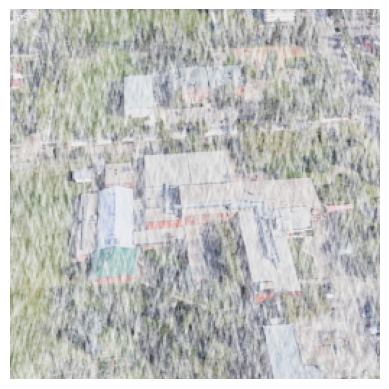

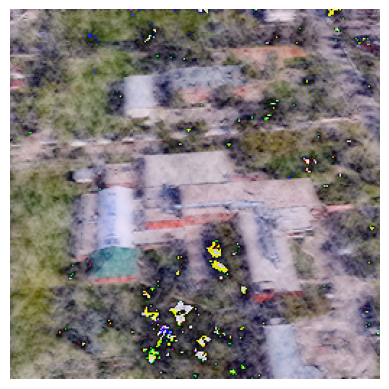

In [14]:
full_test(epoch=1)


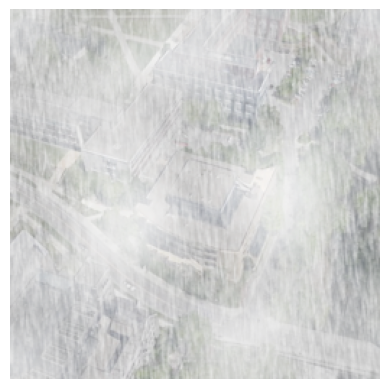

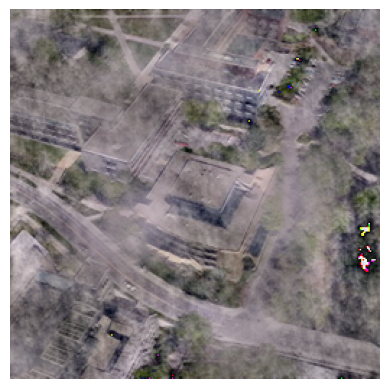

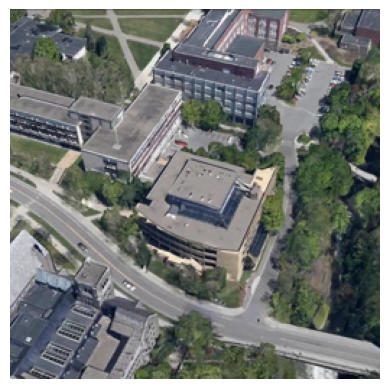

In [9]:
test2(epoch=1, style='fog_rain')

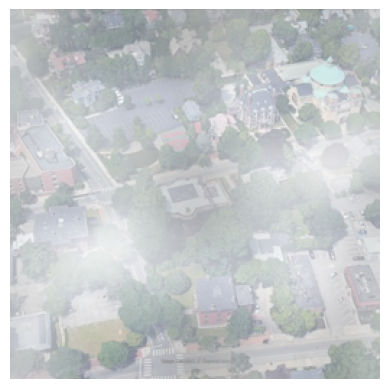

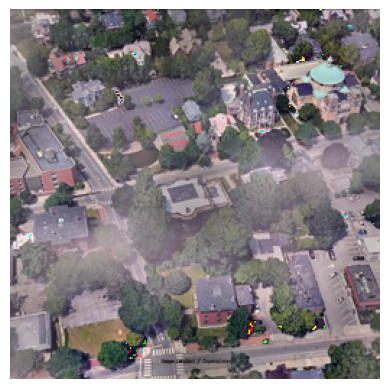

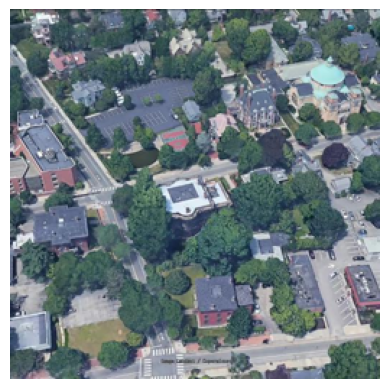

In [19]:
test2(epoch=1, style='fog')

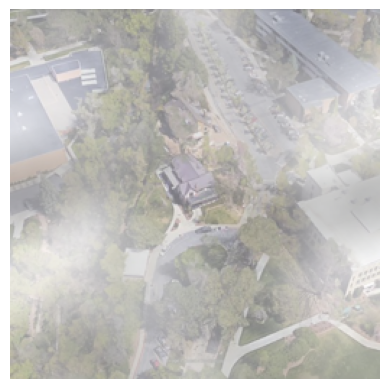

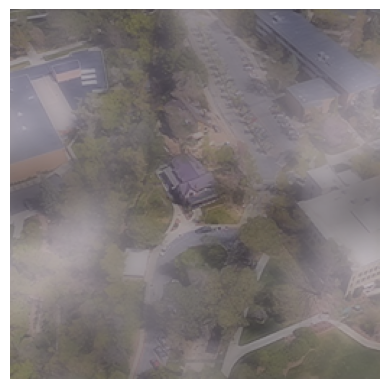

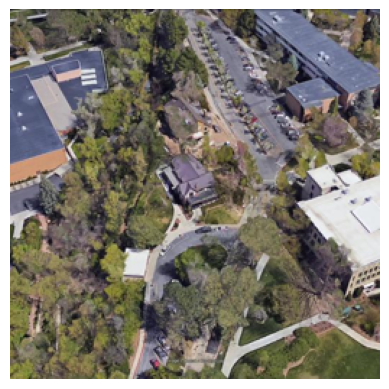

In [12]:
test(epoch=1, style='fog', filter_name='mix')

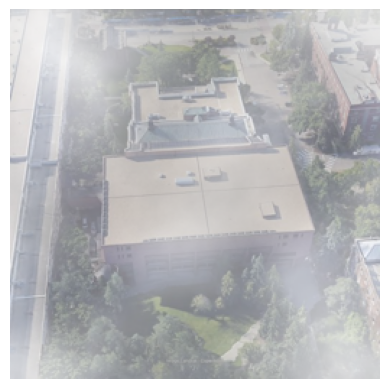

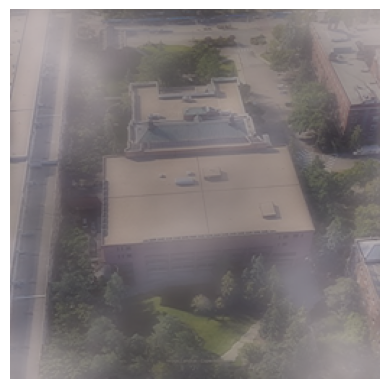

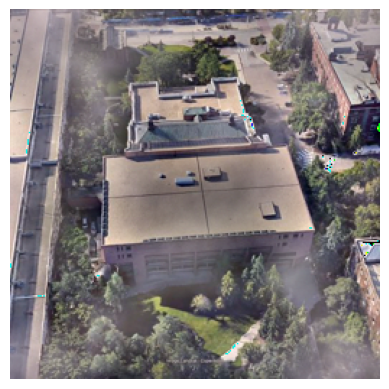

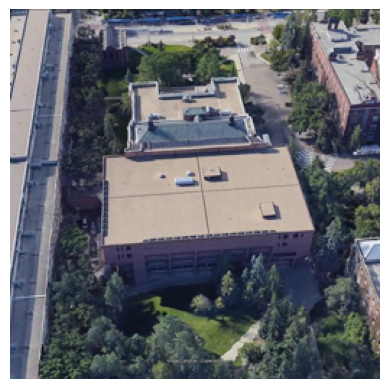

In [21]:
def test_vs(style='fog', batchsize=8, epoch=1):
    learnable_filter1 = FrequencyFilter()
    learnable_filter2 = FrequencyFilter()
    data_set = MyDataset(os.path.join(os.getcwd(), 'University-Release', 'test', 'query_drone'), style=style)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=batchsize, shuffle=True, num_workers=0, pin_memory=False) 
    save_path = os.path.join(os.getcwd(), 'model', 'FFM', '{}_{:03d}.pth'.format('mix', epoch))
    learnable_filter1.load_state_dict(torch.load(save_path)) 

    save_path = os.path.join(os.getcwd(), 'model', 'FFM', '{}_{:03d}.pth'.format(style, epoch))
    learnable_filter2.load_state_dict(torch.load(save_path)) 

    dataiter = iter(data_loader)
    img_aug, img = dataiter.next()
    with torch.no_grad():
        outputs1 = learnable_filter1(img_aug)
        outputs2 = learnable_filter2(img_aug)

    n = np.random.choice(list(range(batchsize)))

    imshow(img_aug[n])
    imshow(outputs1[n])
    imshow(outputs2[n])
    imshow(img[n])

test_vs(style='fog')